create embeddings concated predictions without new_individual  
with weighted-average

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import glob

from tqdm import tqdm
import seaborn as sns
from collections import Counter

import cv2

In [2]:
from sklearn.metrics import pairwise_distances

In [3]:
from collections import Counter
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize

In [4]:
import cudf, cuml, cupy
from cuml.feature_extraction.text import TfidfVectorizer
from cuml.neighbors import NearestNeighbors

In [5]:
train = pd.read_csv("/kaggle/happywhale/input/train.csv")
train.shape

(51033, 3)

In [6]:
train.species.replace({"globis": "short_finned_pilot_whale",
                          "pilot_whale": "short_finned_pilot_whale",
                          "kiler_whale": "killer_whale",
                          "bottlenose_dolpin": "bottlenose_dolphin"}, inplace=True)

In [7]:
test_df = pd.read_csv("/kaggle/happywhale/input/sample_submission.csv")
test_df.shape

(27956, 2)

### concat ensemble

In [8]:
import bz2
import pickle
import _pickle as cPickle

def compressed_pickle(title, data):
    with bz2.BZ2File(title + '.pbz2', 'w') as f:
        cPickle.dump(data, f)
        
def decompress_pickle(file):
    data = bz2.BZ2File(file, 'rb')
    data = cPickle.load(data)
    return data

In [9]:
d = {
    "exp16v4sampler_fold0": 0.8045250039815257,
    "exp16v6AugmixFullB4_fold0": 0.845,
    "exp16v6AugmixB4Full_fold2": 0.8055555555555555,
    "exp16v6AugmixB4Full_fold3": 0.794918796274182,
    "exp16v6AugmixB4Step2_fold0": 0.8076166587036152,
    "exp16v6AugmixB4Step2_fold0_remove_background": 0.8076166587036152,
    "exp16v6AugmixB4Step2_fold1": 0.8130304123091717,
    "exp16v6AugmixB4Step2_fold1_remove_background": 0.8130304123091717,
    "exp16v6AugmixB4Step2_fold2": 0.8126814653959062,
    "exp16v6AugmixB4Step2_fold3": 0.8043706711249105,
    "exp16v6AugmixB4Step2_fold4": 0.7963662272889206,
    "exp16v6AugmixB4_fold0": 0.808689679885332,
    "exp16v6AugmixB4_fold1": 0.8042533157030093,
    "exp16v6AugmixB4_fold2": 0.8105139341295693,
    "exp16v6Augmix_fold0": 0.8142837235228539,
    "exp16v6Augmix_fold1": 0.8226249148535482,
    "exp16v6Augmix_fold2": 0.7819700808300157,
    "exp16v6Augmix_fold3": 0.7878831303240188,
    "exp16v6Augmix_fold4": 0.7934904801488343,
    "exp16v6sampler_fold0": 0.8119127249562033,
    "exp21b6_fold0": 0.7997491638795986,
}

In [10]:
team_files = list(d.keys())

In [11]:
team_weights = list(d.values())

In [12]:
len(team_files )

21

In [13]:
team_weights

[0.8045250039815257,
 0.845,
 0.8055555555555555,
 0.794918796274182,
 0.8076166587036152,
 0.8076166587036152,
 0.8130304123091717,
 0.8130304123091717,
 0.8126814653959062,
 0.8043706711249105,
 0.7963662272889206,
 0.808689679885332,
 0.8042533157030093,
 0.8105139341295693,
 0.8142837235228539,
 0.8226249148535482,
 0.7819700808300157,
 0.7878831303240188,
 0.7934904801488343,
 0.8119127249562033,
 0.7997491638795986]

In [14]:
team_files

['exp16v4sampler_fold0',
 'exp16v6AugmixFullB4_fold0',
 'exp16v6AugmixB4Full_fold2',
 'exp16v6AugmixB4Full_fold3',
 'exp16v6AugmixB4Step2_fold0',
 'exp16v6AugmixB4Step2_fold0_remove_background',
 'exp16v6AugmixB4Step2_fold1',
 'exp16v6AugmixB4Step2_fold1_remove_background',
 'exp16v6AugmixB4Step2_fold2',
 'exp16v6AugmixB4Step2_fold3',
 'exp16v6AugmixB4Step2_fold4',
 'exp16v6AugmixB4_fold0',
 'exp16v6AugmixB4_fold1',
 'exp16v6AugmixB4_fold2',
 'exp16v6Augmix_fold0',
 'exp16v6Augmix_fold1',
 'exp16v6Augmix_fold2',
 'exp16v6Augmix_fold3',
 'exp16v6Augmix_fold4',
 'exp16v6sampler_fold0',
 'exp21b6_fold0']

In [15]:
fold2 = pd.read_csv("/kaggle/happywhale/input/whale-21-3-2022/fold2.csv")
fold2.shape

(51033, 8)

In [16]:
fold2_dict=dict()

fold2_images = fold2.image.values

for i in range(len(fold2)):
    fold2_dict[fold2_images[i]] = i

new_index = []
org_train_image=train.image.values

for i in range(len(train)):
    new_index.append(fold2_dict[org_train_image[i]])
    

In [17]:
def get_embeddings(files,weights):
    
    DIRNAME ="../input/whale-21-3-2022/"

    train_emb_lis = []
    test_emb_lis  = []
    
    for fname,w in zip(files,weights):

        wei=w**2
        print(fname,wei)
        
        
        data = decompress_pickle(DIRNAME + fname + ".pbz2")
        
        train_emb = data["emb_val"][new_index,:]
        test_emb  = data["emb_test"]

        train_emb=normalize(train_emb)
        test_emb=normalize(test_emb)
        
        train_emb*=wei
        test_emb*=wei
        
        train_emb_lis.append(train_emb)
        test_emb_lis.append(test_emb)
        
        print("    ",train_emb.shape,test_emb.shape)
    
    ret_train = normalize(np.concatenate(train_emb_lis,axis=1))
    ret_test  = normalize(np.concatenate(test_emb_lis,axis=1))
        
    return ret_train,ret_test
    

In [18]:
train_emb,test_emb = get_embeddings(team_files,team_weights)

exp16v4sampler_fold0 0.6472604820314739
     (51033, 512) (27956, 512)
exp16v6AugmixFullB4_fold0 0.7140249999999999
     (51033, 1024) (27956, 1024)
exp16v6AugmixB4Full_fold2 0.6489197530864196
     (51033, 512) (27956, 512)
exp16v6AugmixB4Full_fold3 0.6318958926699946
     (51033, 512) (27956, 512)
exp16v6AugmixB4Step2_fold0 0.6522446674155917
     (51033, 512) (27956, 512)
exp16v6AugmixB4Step2_fold0_remove_background 0.6522446674155917
     (51033, 512) (27956, 512)
exp16v6AugmixB4Step2_fold1 0.6610184513396218
     (51033, 512) (27956, 512)
exp16v6AugmixB4Step2_fold1_remove_background 0.6610184513396218
     (51033, 512) (27956, 512)
exp16v6AugmixB4Step2_fold2 0.6604511641980375
     (51033, 512) (27956, 512)
exp16v6AugmixB4Step2_fold3 0.6470121765659389
     (51033, 512) (27956, 512)
exp16v6AugmixB4Step2_fold4 0.6341991679663888
     (51033, 512) (27956, 512)
exp16v6AugmixB4_fold0 0.6539789983530407
     (51033, 512) (27956, 512)
exp16v6AugmixB4_fold1 0.6468233958192843
     (51033

In [19]:
train_emb.shape,test_emb.shape

((51033, 11264), (27956, 11264))

### test pred

In [20]:
%%time

#new_distances = cuml.metrics.pairwise_distances(test_emb,train_emb)
distances = pairwise_distances(test_emb,train_emb)

CPU times: user 15min 42s, sys: 6min 37s, total: 22min 19s
Wall time: 2min 1s


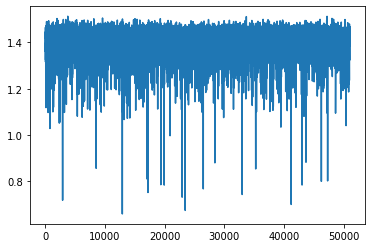

In [21]:
plt.plot(distances[0])

In [22]:
%%time

K=1000
predicted_positions1 = np.argpartition(distances[:10000], K, axis=1)[:, :K]
predicted_positions2 = np.argpartition(distances[10000:20000], K, axis=1)[:, :K]
predicted_positions3 = np.argpartition(distances[20000:], K, axis=1)[:, :K]

CPU times: user 11.2 s, sys: 1.45 s, total: 12.7 s
Wall time: 12.7 s


In [23]:
predicted_positions = np.vstack([predicted_positions1,predicted_positions2,predicted_positions3])
predicted_positions.shape

(27956, 1000)

In [24]:
predicted_positions

array([[17196, 50620, 33125, ...,  1535, 41859, 13862],
       [37455,  1427, 25644, ..., 42855, 29999,   407],
       [20287, 49210, 28619, ...,  9312, 44788,  3574],
       ...,
       [39201,  3480, 34328, ..., 21616, 33112, 22364],
       [24612, 18673, 25177, ..., 36938, 20817,  6954],
       [17983, 37945, 37923, ..., 17637, 21467, 11399]])

In [25]:
sub_pred_lis = []

train_inddividual_id_lis = train["individual_id"].values


for i in tqdm(range(predicted_positions.shape[0])):
    nearest = [(train_inddividual_id_lis[j], distances[i, j]) for j in predicted_positions[i]]
    nearest.sort(key=lambda x: x[1])

    prediction = [index_id for index_id, d in nearest]
    
    done = set()
    pred_list = []
    for pred_id in prediction:
        if pred_id in done:
            continue
        done.add(pred_id)
        pred_list.append(pred_id)
        if len(pred_list)==5:
            break    

            
    sub_pred_lis.append(pred_list)

100%|██████████| 27956/27956 [00:30<00:00, 925.71it/s]


In [26]:
pred_lis_joined = []
for preds in sub_pred_lis:
    pred_lis_joined.append(" ".join(preds))

In [27]:
test_df["predictions"] = pred_lis_joined

In [28]:
test_df

,image,predictions
0,000110707af0ba.jpg,fbe2b15b5481 6d1cc6d00dca 5ec416e8a0a1 9513dd8...
1,0006287ec424cb.jpg,1424c7fec826 c3b7d902e73c f0efb5bcc5d3 e72a502...
2,000809ecb2ccad.jpg,1ce3ba6a3c29 82f26bb1adae 50af5f0533c5 b91c12f...
3,00098d1376dab2.jpg,c4274d90be60 2781acdf5508 b5db2ecef12d 27be93c...
4,000b8d89c738bd.jpg,cf500d3874bc c88cb1224033 d4d2cd407a48 396610a...
...,...,...
27951,fff6ff1989b5cd.jpg,734573d54bef 843297d1983b ec0aa394b7e5 79d85d2...
27952,fff8fd932b42cb.jpg,d02966ca2974 6ee0efae585c 4e376cb4fd38 357b067...
27953,fff96371332c16.jpg,8949de1830d1 dc4082105594 9d86367bdff7 2ea061e...
27954,fffc1c4d3eabc7.jpg,e7f9e93184b9 a8fe10f7b3e0 d85f2d5186cb fd53cdc...


In [29]:
test_df.to_csv("team_21model_concat_weighted_average.csv",index=None)